# Multi-label tourism image classification-- using transfer learning

Use keras (using TensorFlow backend) to classify multi-label images, and the image data has been pre-processed.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical

from tensorflow.python.keras import optimizers, regularizers, applications
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential , Model
from tensorflow.python.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D

import tensorflow as tf

plt.style.use('ggplot')
plt.switch_backend('agg')
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"         #GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2427473433051780724
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6620742943
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14144623822299608883
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## 1、 Setting parameters

In [3]:
EPOCHS = 20
BATCH_SIZE = 32
img_size = 192
dropout_rate = 0.5

## 2、Building a pretrained image classification model
using transfer learning

In [5]:
## Plot model evaluation indicators
def overfitting_plot(history, name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('accuracy  '+name)
    plt.legend(loc='best')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('loss '+name)
    plt.legend(loc='best')
    plt.savefig('loss_'+name+'.png')


## Choose a transfer learning modeler
def model_base(img_size,freeze_conv=True, name=' '):
    print(img_size,',',name)
    if(name == 'VGG16'):
        amodel = applications.VGG16(include_top=False,
                                   input_shape=(img_size,img_size,3), 
                                   weights='imagenet')

    if(name == 'VGG16T'):
        amodel = applications.VGG16(include_top=True,
                                   input_shape=(img_size,img_size,3), 
                                   weights='imagenet')
        
    if(name == 'VGG19'):
        amodel = applications.VGG19(include_top=False,
                                   input_shape=(img_size,img_size,3), 
                                   weights='imagenet')
        
    if(name == 'InceptionV3'):
        amodel = applications.InceptionV3(include_top=False,
                                         input_shape=(img_size,img_size,3), 
                                         weights='imagenet')
    
    if(name == 'IncetionResNetV2'):
        amodel = applications.InceptionResNetV2(include_top=False,
                                         input_shape=(img_size,img_size,3), 
                                         weights='imagenet')

    if(name == 'resnet50'):
        amodel = applications.ResNet50(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')
    if(name == 'Xception'):
        amodel = applications.Xception(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')
        
    if(name == 'DenseNet121'):
        amodel = applications.DenseNet121(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')
        
    if(name == 'DenseNet169'):
        amodel = applications.DenseNet169(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')
    if(name == 'DenseNet201'):
        amodel = applications.DenseNet201(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')

    if(name == 'NASNet1'):
        amodel = applications.NASNetLarge(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights='imagenet')
    if(name == 'NASNet'):
        amodel = applications.NASNetLarge(include_top=False,
                                               input_shape=(img_size,img_size,3), 
                                               weights=None)
        amodel.load_weights("NASNet-large-no-top.h5",by_name=True)
        
    if(freeze_conv):
        amodel.trainable = False
        
    else:
        amodel.trainable = True
        
        
    return amodel


#Constructing a pre-trained model
def pretrained_model(img_size,name='DenseNet169',with_dropout=False, with_regularizer=False, regularizer_weight=0.005):
    
    model_pretrained = model_base(img_size,freeze_conv=True,name=name)
    model = Sequential()
    model.add(model_pretrained)
    
    model.add(GlobalAveragePooling2D(input_shape=(7,7,1024),data_format='channels_last'))
    #model.add(Flatten())

    if with_dropout:
        model.add(Dropout(0.4))
        
    if with_regularizer:
        model.add(Dense(256, activation='relu',
                        kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight, l2=regularizer_weight)))
    else:
        model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))      #tf.nn.softmax
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-5), 
                  metrics=['acc'])
    return model


## Perform model training
def train(img_size,name,epochs):
    X_train='X_train%dN.npy'%(img_size)
    y_train='y_train%dN.npy'%(img_size)
    X_test='X_test%dN.npy'%(img_size)
    y_test='y_test%dN.npy'%(img_size)

    Xtrain=np.load(X_train)
    Ytrain=np.load(y_train)
    Xvalid=np.load(X_test)
    Yvalid=np.load(y_test)
    
    model=pretrained_model(img_size,name)  
    trained_model = model.fit(Xtrain, Ytrain, epochs = epochs, shuffle = True, batch_size = 32,validation_data=(Xvalid, Yvalid))
    
    print(img_size,'Model training completed！')
    title=name+str(img_size)
    overfitting_plot(trained_model, title)


## 3、Training model

The image size set for this training is 192*192, the selected transfer learning model is densenet169, and the number of iterations is 30 times.

192 , DenseNet169
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 21677 samples, validate on 9274 samples
Epoch 1/30
21677/21677 [==============================] - 98s 5ms/sample - loss: 2.9381 - acc: 0.2027 - val_loss: 2.2986 - val_acc: 0.3290
Epoch 2/30
21677/21677 [==============================] - 90s 4ms/sample - loss: 2.2665 - acc: 0.3590 - val_loss: 1.8652 - val_acc: 0.4391
Epoch 3/30
21677/21677 [==============================] - 90s 4ms/sample - loss: 1.9075 - acc: 0.4499 - val_loss: 1.5656 - val_acc: 0.5187
Epoch 4/30
21677/21677 [==============================] - 90s 4ms/sample - loss: 1.6684 - acc: 0.5136 - val_loss: 1.3802 - val_acc: 0.5678
Epoch 5/30
21677/21677 [==============================] - 90s 4ms/sample - loss: 1.4922 - acc: 0.5558 - val_loss: 1.2172 - val_acc: 0.6154
Epoch 6/30
21677/21677 [==============================] - 90s 4ms/sample - loss: 1.3574 - acc: 0.5880 - val_loss: 1.1176

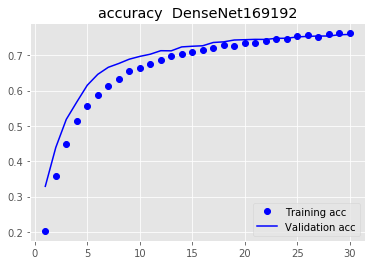

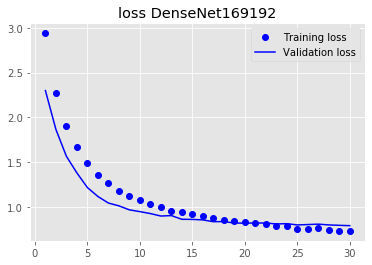

In [6]:
train(192,'DenseNet169',30)

It can be seen from the above experiments that the number of iterations can also be increased to improve the accuracy of the model.

Here is a compilation of information for reference, only trained 30 times.

## 4、Train various transfer learning models on different image sizes

### using  “1  Data Preprocessing & save to npy”  to generate image data of different sizes
#### For example 288 * 288、331*331

In [ ]:
trained_model=train(288,'DenseNet169',50)
overfitting_plot(trained_model, '331')
trained_model=train(331,'DenseNet169',50)
overfitting_plot(trained_model, '331')

288 , DenseNet169
Train on 21677 samples, validate on 9274 samples
Epoch 1/50
21677/21677 [==============================] - 246s 11ms/sample - loss: 0.9648 - acc: 0.7067 - val_loss: 0.7458 - val_acc: 0.7712
Epoch 2/50
21677/21677 [==============================] - 227s 10ms/sample - loss: 0.3832 - acc: 0.8743 - val_loss: 0.6776 - val_acc: 0.7988
Epoch 3/50
21677/21677 [==============================] - 227s 10ms/sample - loss: 0.1914 - acc: 0.9374 - val_loss: 0.6925 - val_acc: 0.8032
Epoch 4/50
21677/21677 [==============================] - 227s 10ms/sample - loss: 0.1151 - acc: 0.9611 - val_loss: 0.6744 - val_acc: 0.8131
Epoch 5/50
21677/21677 [==============================] - 227s 10ms/sample - loss: 0.0723 - acc: 0.9752 - val_loss: 0.7340 - val_acc: 0.8102
Epoch 6/50
21677/21677 [==============================] - 227s 10ms/sample - loss: 0.0513 - acc: 0.9826 - val_loss: 0.7049 - val_acc: 0.8249
Epoch 7/50
21677/21677 [==============================] - 228s 10ms/sample - loss: 0.03

### You can also choose different transfer learning models to test which one works better

For example ：
   -     trained_model=train(224,'DenseNet201',10)
   -     overfitting_plot(trained_model, '224')
   -     trained_model=train(288,'DenseNet201',10)
   -     overfitting_plot(trained_model, '288')
   -     trained_model=train(331,'DenseNet201',10)
   -     overfitting_plot(trained_model, '331')